In [1]:
### Install necessary packages
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q monai
!pip install -q datasets

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://g

In [377]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import monai
import noisereduce as nr
import numpy as np 
import os
import obspy
from PIL import Image
from statistics import mean
import torch
import torch.nn.functional as F
from torch.nn.functional import threshold, normalize
from torch.optim import Adam
from torch.utils.data import Dataset,DataLoader
from transformers import SamModel, SamProcessor
from tqdm import tqdm
from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"

# use this dataset to learn how to create a new dataset
dataset1 = load_dataset("nielsr/breast-cancer", split="train")

2023-05-29 18:33:21,655 - Found cached dataset parquet (/Users/josesmac/.cache/huggingface/datasets/nielsr___parquet/nielsr--breast-cancer-c16ee7932c43ffa3/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


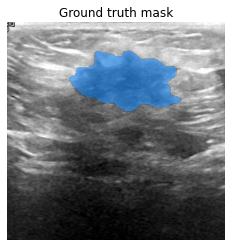

In [379]:
example = dataset1[0]
image = example["image"]

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"]) # Convert the PIL image to a numpy array
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")
plt.show()

### Create bounding boxes around the images

In [3]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20)) # Compare the box xmin to the left edge of the array
    x_max = min(W, x_max + np.random.randint(0, 20)) # Compare the box xmax to the right edge of the array
    y_min = max(0, y_min - np.random.randint(0, 20)) # Compare the box ymin to the bottom edge of the array
    y_max = min(H, y_max + np.random.randint(0, 20)) # Compare the box ymax to the top edge of the array
    bbox = [x_min, y_min, x_max, y_max]

    return bbox
     

### Functions for creating the dataset

In [530]:
class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

class SAMDASDataset(Dataset):
    def __init__(self, dataset, processor, pclip):
        '''datset is a list of dictionaries with the path and bounding box'''
        self.dataset = dataset
        self.processor = processor
        self.pclip = pclip

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Load the obspy stream object
        stream = obspy.read(item["path"],format='segy')
        stream = stream.detrend('demean')
        stream = stream.filter('highpass',freq=1)
        stream = stream.interpolate(200)
        
        # Convert the geophone/DAS stream to 2D normalized image object
        image = stream_to_image(stream,pclip=self.pclip)

        # get bounding box prompt
        prompt = item["label"]
        
        # Create the ground truth mas from the label bounding box
        ground_truth_mask = np.zeros_like(image)
        ground_truth_mask[prompt[0]:prompt[2],prompt[1]:prompt[3]] = 1

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs
    
def stream_to_image(stream,pclip=95):
    '''
    Function to convert obspy stream to image file that can be fed into SAM
    
    Parameters.
        stream: obspy Stream object
        pclip: percentile, value to normalize array to.
    
    Returns.
        image as type np.unint8 ranging between 0 and 255
    '''

    data = np.column_stack([tr.data for tr in stream])
    
    # Clip the input data to the 95th percentile to remove outlier values
    clipVal = np.percentile(np.absolute(data), pclip)
    data = np.where(data>clipVal,clipVal,data)
    data = np.where(data<-clipVal,-clipVal,data)
    
    # Normalize the data between 0 and 1 and multiply by 255 to create an image file
    normalized_array = ((data - data.min()) / (data.max() - data.min())) * 255

    # Convert array to unsigned 8-bit integers
    uint8_array = normalized_array.astype(np.uint8)

    # Create PIL image from the array
    image = Image.fromarray(uint8_array)
    
    image = image.resize((3600,3200), Image.Resampling.LANCZOS) # (width,height)
    
    return image

### Download Geophone data from the FORGE Experiment
Each file contains 36 channels sampled at 2000Hz. The data is downsampled to 200Hz. <br>
The first 2 files are used for training, and the last one is used for testing

In [456]:
os.system("wget --no-check-certificate https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427172549.868.segy")
os.system("wget --no-check-certificate https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427172621.868.segy")
os.system("wget --no-check-certificate https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427172709.868.segy")

--2023-05-29 19:37:35--  https://pando-rgw01.chpc.utah.edu/slb_2019_MW78-32_014/20190427172549.868.segy
Resolving pando-rgw01.chpc.utah.edu (pando-rgw01.chpc.utah.edu)... 155.101.11.35
Connecting to pando-rgw01.chpc.utah.edu (pando-rgw01.chpc.utah.edu)|155.101.11.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4620240 (4.4M) [application/octet-stream]
Saving to: ‘20190427172549.868.segy.1’

     0K .......... .......... .......... .......... ..........  1%  398K 11s
    50K .......... .......... .......... .......... ..........  2%  893K 8s
   100K .......... .......... .......... .......... ..........  3% 1.13M 7s
   150K .......... .......... .......... .......... ..........  4% 4.96M 5s
   200K .......... .......... .......... .......... ..........  5%  495K 6s
   250K .......... .......... .......... .......... ..........  6% 1.61M 5s
   300K .......... .......... .......... .......... ..........  7% 1.35M 5s
   350K .......... .......... .......... ...

   250K .......... .......... .......... .......... ..........  6%  734K 5s
   300K .......... .......... .......... .......... ..........  7% 1.20M 5s
   350K .......... .......... .......... .......... ..........  8% 1.16M 5s
   400K .......... .......... .......... .......... ..........  9%  966K 4s
   450K .......... .......... .......... .......... .......... 11% 2.21M 4s
   500K .......... .......... .......... .......... .......... 12%  998K 4s
   550K .......... .......... .......... .......... .......... 13%  828K 4s
   600K .......... .......... .......... .......... .......... 14% 2.25M 4s
   650K .......... .......... .......... .......... .......... 15%  967K 4s
   700K .......... .......... .......... .......... .......... 16% 1.39M 4s
   750K .......... .......... .......... .......... .......... 17% 1.06M 4s
   800K .......... .......... .......... .......... .......... 18%  973K 4s
   850K .......... .......... .......... .......... .......... 19%  724K 4s
   900K ....

   750K .......... .......... .......... .......... .......... 17%  898K 3s
   800K .......... .......... .......... .......... .......... 18%  864K 3s
   850K .......... .......... .......... .......... .......... 19% 1.06M 3s
   900K .......... .......... .......... .......... .......... 21% 1.08M 3s
   950K .......... .......... .......... .......... .......... 22% 2.93M 3s
  1000K .......... .......... .......... .......... .......... 23% 1.03M 3s
  1050K .......... .......... .......... .......... .......... 24% 1.19M 3s
  1100K .......... .......... .......... .......... .......... 25% 1.11M 3s
  1150K .......... .......... .......... .......... .......... 26% 2.14M 3s
  1200K .......... .......... .......... .......... .......... 27%  889K 3s
  1250K .......... .......... .......... .......... .......... 28% 1.39M 3s
  1300K .......... .......... .......... .......... .......... 29% 1.16M 3s
  1350K .......... .......... .......... .......... .......... 31% 1.27M 3s
  1400K ....

0

### Define the SAM data processor

In [5]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

### Create a list of dictionaries for the dataset

In [531]:
# Create dictionaries detailing the path to the segy files
file1,file2 = dict(),dict()
file1["path"] = "20190427172549.868.segy"
file1["label"] = [500, 0, 580, 3600]
file2["path"] = "20190427172549.868.segy"
file2["label"] = [1300, 0, 1500, 3600]
dataset = [file1,file2]

### Create the training dataset

In [532]:
train_dataset = SAMDASDataset(dataset=dataset, processor=processor, pclip=97)

# Print one batch from the training dataset
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (3200, 3600)


### Load the Dataset into a pytorch Dataloader

In [533]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [534]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
print(f"The ground truth mask shape is {batch['ground_truth_mask'].shape}")

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 3200, 3600])
The ground truth mask shape is torch.Size([2, 3200, 3600])


### Download the SAM base model files

In [466]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

### Define the function to resize the input masks during training

In [535]:
def postprocess_masks(masks: torch.Tensor, 
                      input_size: Tuple[int, ...], 
                      original_size: Tuple[int, ...], 
                      image_size=256) -> torch.Tensor:
    """
    Remove padding and upscale masks to the original image size.

    Args:
      masks (torch.Tensor):
        Batched masks from the mask_decoder, in BxCxHxW format.
      input_size (tuple(int, int)):
        The size of the image input to the model, in (H, W) format. Used to remove padding.
      original_size (tuple(int, int)):
        The original size of the image before resizing for input to the model, in (H, W) format.

    Returns:
      (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
        is given by original_size.
    """
    masks = F.interpolate(masks, (image_size, image_size), mode="bilinear", align_corners=False,)
    masks = masks[..., : input_size[0], : input_size[1]]
    masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
    return masks


### Train the model for 3 epochs

In [536]:
num_epochs = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # compute loss
        low_res_masks = outputs.pred_masks#.squeeze(1)
        upscaled_masks = postprocess_masks(low_res_masks.squeeze(1), 
                                           batch["reshaped_input_sizes"][0].tolist(), 
                                           batch["original_sizes"][0].tolist()).to(device)
        predicted_masks = normalize(threshold(upscaled_masks, 0.0, 0))#.squeeze(1)
#         predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
     

100%|█████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.62s/it]


EPOCH: 0
Mean loss: 0.8547780513763428


100%|█████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.24s/it]


EPOCH: 1
Mean loss: 0.8546314239501953


100%|█████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.03s/it]

EPOCH: 2
Mean loss: 0.8545734882354736


# Inference on the holdout dataset

In [549]:
stream = obspy.read('20190427172709.868.segy',format='segy')
dt = stream[0].stats.delta

stream = stream.detrend('demean')
stream = stream.filter('highpass',freq=1)
stream = stream.interpolate(200)

dt_rs = stream[0].stats.delta
print(f"The original data sampling frequency is {1/dt:.0f} Hz, and it has been resampled to {1/dt_rs:.0f} Hz.")

The original data sampling frequency is 2000 Hz, and it has been resampled to 200 Hz.


### Create an image file, and preprocess it using the ground truth labels bounding boxes

In [550]:
image = stream_to_image(stream,pclip=95)
# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[[2540, 1300, 2650, 3600]]], return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


### Plot the first 36 traces

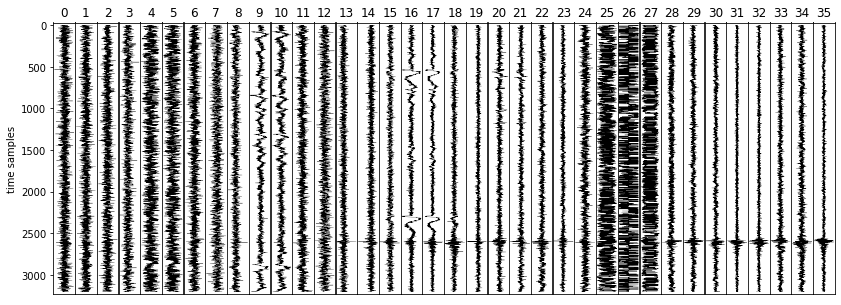

In [551]:
fig,ax = plt.subplots(1,36, figsize=(14,5),gridspec_kw={'wspace':0.01})
for i,v in enumerate(stream[:36]):
    ax[i].plot(np.array(image)[:,i*100],np.arange(data.shape[0]),lw=0.25,c='k')
    ax[i].invert_yaxis(),ax[i].set_xticks([]),ax[i].set_title(i),ax[i].margins(y=0.01)
    
    if i!=0: ax[i].set_yticks([])
    if i==0: ax[i].set_ylabel('time samples')
plt.show()

### Predict on the single file

In [552]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)
    # Rescale the output mask from 256x256 to the input data dimension
    upscaled_masks = postprocess_masks(outputs.pred_masks.squeeze(1),
                                       inputs["reshaped_input_sizes"][0].tolist(), 
                                       inputs["original_sizes"][0].tolist()).to(device)
    predicted_masks = normalize(threshold(upscaled_masks, 0.0, 0))
    predicted_masks = predicted_masks.squeeze(0).squeeze(0).detach().numpy()

### Plot the input data and predicted labels

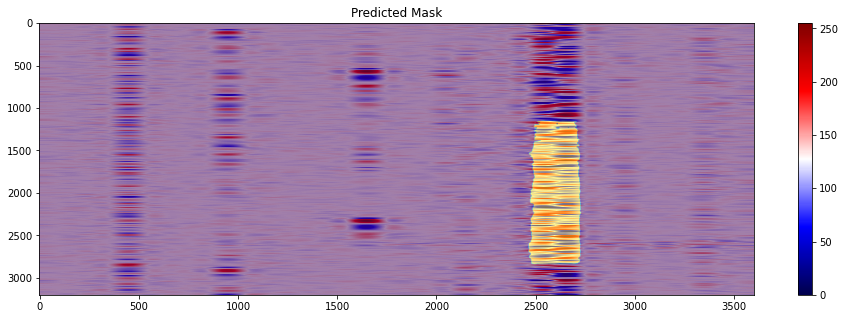

In [555]:
fig,ax = plt.subplots(figsize=(16,5))
im = ax.imshow(np.array(image),vmin=0,vmax=255,aspect='auto',cmap='seismic',interpolation='bilinear',)
ax.imshow(predicted_masks,aspect='auto',alpha=0.5,)
fig.colorbar(mappable=im)
ax.set_title('Predicted Mask')
plt.show()

# Zero-shot predictions using pixels with SAM-VIT-HUGE

In [515]:
from transformers import pipeline
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image,alpha=0.5)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image),cmap='seismic')
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()

### Download the model and config files

In [474]:
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=device)

### Perform inference with the SAM-visual-transformer large model

In [528]:
# If the width to height ratio is too large e.g(3200,36) it won't generate any masks
# So I interpolated the 36 channels to cover 100 pixels each to even out the ratio
image2 = image.resize((3600,3200), Image.Resampling.LANCZOS) # (width, height)
outputs = generator(image2, points_per_batch=64)
masks = outputs["masks"]

### Plot the masks

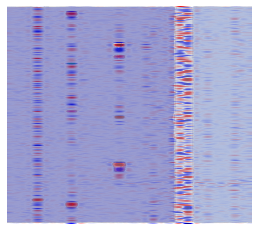

In [529]:
show_masks_on_image(image2,masks)